<a href="https://colab.research.google.com/github/Kryptera-K/AFL-SuperTrend-Stochastic-Reversal-Strategy/blob/main/AFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "AFL"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("AFL_clean.csv", index=False)
df

/tmp/ipython-input-3521436545.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,6.703293,7.059054,6.637758,7.030968,2388800
2000-01-04,6.525413,6.759467,6.478602,6.478602,2716400
2000-01-05,6.487959,6.619029,6.469235,6.534770,1354800
2000-01-06,6.619030,6.656479,6.422426,6.459874,2027200
2000-01-07,6.750106,6.759468,6.572225,6.609674,2262000
...,...,...,...,...,...
2025-10-29,105.699997,106.839996,105.430000,106.360001,1668700
2025-10-30,106.839996,107.500000,105.779999,105.970001,1503000
2025-10-31,107.190002,107.629997,105.750000,105.849998,2608900


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

SUPERTREND_PERIOD = 14
SUPERTREND_MULTIPLIER = 3
STOCHASTIC_K_PERIOD = 14       # Fast %K period
STOCHASTIC_D_PERIOD = 3        # Slow %D period
STOCHASTIC_OVERSOLD = 20       # Oversold level

# -------------------------
# Indicator Functions
# -------------------------

def slow_d_cross_below_oversold(df, level=STOCHASTIC_OVERSOLD):
    df = calculate_stochastic(df)
    return (df['Slow_%D'].shift(1) > level) & (df['Slow_%D'] < level)


def calculate_stochastic(df, k_period=STOCHASTIC_K_PERIOD, d_period=STOCHASTIC_D_PERIOD):
    """Calculate Fast %K and Slow %D"""
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()

    df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df['Slow_%D'] = df['Fast_%K'].rolling(window=d_period).mean()
    return df


def close_below_st(df):
    df = calculate_supertrend(df)
    return df['Close'] < df['Lower_Band']


def calculate_supertrend(df, period=SUPERTREND_PERIOD, multiplier=SUPERTREND_MULTIPLIER):
    """Calculate SuperTrend, Upper Band, and Lower Band"""
    hl2 = (df['High'] + df['Low']) / 2

    # True Range
    tr1 = df['High'] - df['Low']
    tr2 = abs(df['High'] - df['Close'].shift())
    tr3 = abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # ATR
    atr = tr.rolling(period).mean()

    # Basic Bands
    upper_basic = hl2 + multiplier * atr
    lower_basic = hl2 - multiplier * atr

    # Initialize final bands
    upper_band = upper_basic.copy()
    lower_band = lower_basic.copy()

    # SuperTrend list
    supertrend = [True]  # True = Uptrend, False = Downtrend

    for i in range(1, len(df)):
        # Upper Band
        if df['Close'].iloc[i-1] <= upper_band.iloc[i-1]:
            upper_band.iloc[i] = min(upper_basic.iloc[i], upper_band.iloc[i-1])

        # Lower Band
        if df['Close'].iloc[i-1] >= lower_band.iloc[i-1]:
            lower_band.iloc[i] = max(lower_basic.iloc[i], lower_band.iloc[i-1])

        # SuperTrend determination
        if df['Close'].iloc[i] > upper_band.iloc[i-1]:
            supertrend.append(True)
        elif df['Close'].iloc[i] < lower_band.iloc[i-1]:
            supertrend.append(False)
        else:
            supertrend.append(supertrend[-1])

    df['SuperTrend'] = supertrend
    df['Upper_Band'] = upper_band
    df['Lower_Band'] = lower_band

    return df


# -------------------------
# Entry conditions
# -------------------------

df["Slow_%D_Cross_Below_Oversold"] = slow_d_cross_below_oversold(df)

# -------------------------
# Exit conditions
# -------------------------

df["Close_Below_ST"] = close_below_st(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Slow_%D_Cross_Below_Oversold',
]
exit_conditions = [
    'Close_Below_ST',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-11-04 00:00:00
Period                                6500 days 00:00:00
Start Value                                     100000.0
End Value                                 1913296.003871
Total Return [%]                             1813.296004
Benchmark Return [%]                         1434.212731
Max Gross Exposure [%]                             100.0
Total Fees Paid                             89302.084342
Max Drawdown [%]                               67.068025
Max Drawdown Duration                 1228 days 00:00:00
Total Trades                                          96
Total Closed Trades                                   95
Total Open Trades                                      1
Open Trade PnL                              -5032.086313
Win Rate [%]                                   42.105263
Best Trade [%]                                 63.923919
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-11-04 00:00:00
Period                         6500 days 00:00:00
Start Value                              100000.0
End Value                          1534212.731136
Total Return [%]                      1434.212731
Benchmark Return [%]                  1434.212731
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         83.33815
Max Drawdown Duration          1323 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     1434212.731136
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1614158036.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


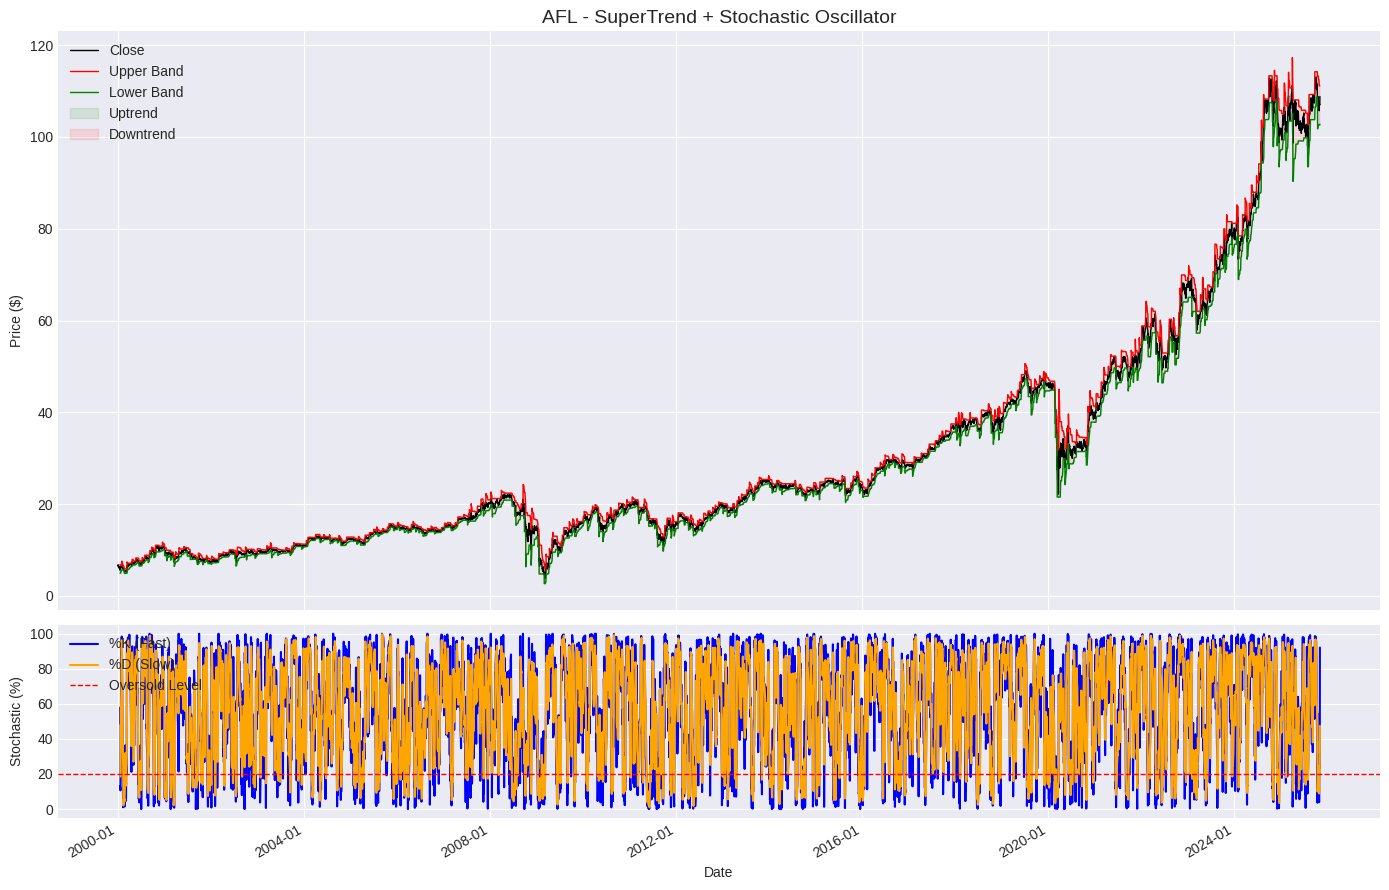

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -------------------------
# Download Data
# -------------------------
symbol = "AFL"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Parameters
# -------------------------
SUPERTREND_PERIOD = 14
SUPERTREND_MULTIPLIER = 3
STOCHASTIC_K_PERIOD = 14
STOCHASTIC_D_PERIOD = 3
STOCHASTIC_OVERSOLD = 20

# -------------------------
# Indicator Functions
# -------------------------
def calculate_stochastic(df, k_period=STOCHASTIC_K_PERIOD, d_period=STOCHASTIC_D_PERIOD):
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()
    df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df['Slow_%D'] = df['Fast_%K'].rolling(window=d_period).mean()
    return df

def calculate_supertrend(df, period=SUPERTREND_PERIOD, multiplier=SUPERTREND_MULTIPLIER):
    hl2 = (df['High'] + df['Low']) / 2
    tr1 = df['High'] - df['Low']
    tr2 = abs(df['High'] - df['Close'].shift())
    tr3 = abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(period).mean()

    upper_basic = hl2 + multiplier * atr
    lower_basic = hl2 - multiplier * atr
    upper_band = upper_basic.copy()
    lower_band = lower_basic.copy()

    supertrend = [True]  # True = Uptrend, False = Downtrend

    for i in range(1, len(df)):
        if df['Close'].iloc[i-1] <= upper_band.iloc[i-1]:
            upper_band.iloc[i] = min(upper_basic.iloc[i], upper_band.iloc[i-1])
        if df['Close'].iloc[i-1] >= lower_band.iloc[i-1]:
            lower_band.iloc[i] = max(lower_basic.iloc[i], lower_band.iloc[i-1])

        if df['Close'].iloc[i] > upper_band.iloc[i-1]:
            supertrend.append(True)
        elif df['Close'].iloc[i] < lower_band.iloc[i-1]:
            supertrend.append(False)
        else:
            supertrend.append(supertrend[-1])

    df['SuperTrend'] = supertrend
    df['Upper_Band'] = upper_band
    df['Lower_Band'] = lower_band
    return df

# -------------------------
# Apply Indicators
# -------------------------
df = calculate_supertrend(df)
df = calculate_stochastic(df)

# -------------------------
# Plotting
# -------------------------
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- Price & SuperTrend ---
ax1.plot(df.index, df['Close'], label='Close', color='black', linewidth=1)
ax1.plot(df.index, df['Upper_Band'], label='Upper Band', color='red', linewidth=1)
ax1.plot(df.index, df['Lower_Band'], label='Lower Band', color='green', linewidth=1)

# Fill up/down trend
ax1.fill_between(df.index, df['Lower_Band'], df['Upper_Band'],
                 where=df['SuperTrend'], color='green', alpha=0.1, label='Uptrend')
ax1.fill_between(df.index, df['Lower_Band'], df['Upper_Band'],
                 where=~df['SuperTrend'], color='red', alpha=0.1, label='Downtrend')

ax1.set_title(f'{symbol} - SuperTrend + Stochastic Oscillator', fontsize=14)
ax1.set_ylabel('Price ($)')
ax1.legend(loc='upper left')

# --- Stochastic Oscillator ---
ax2.plot(df.index, df['Fast_%K'], label='%K (Fast)', color='blue')
ax2.plot(df.index, df['Slow_%D'], label='%D (Slow)', color='orange')
ax2.axhline(y=STOCHASTIC_OVERSOLD, color='red', linestyle='--', linewidth=1, label='Oversold Level')

ax2.set_ylabel('Stochastic (%)')
ax2.set_xlabel('Date')
ax2.legend(loc='upper left')

# Format date x-axis
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()
